Raw CSV files acquired from (https://data.medicare.gov/data/inpatient-rehabilitation-facility-compare).

In [169]:
import pandas as pd

In [170]:
conditions = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - Conditions.csv')
general_info = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - General Information.csv')
provider_data = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - Provider data.csv')
national_data = pd.read_csv('data/Inpatient_Rehab_Facilities_-_Revised_Flat_Files/Inpatient Rehab Facility - National data.csv')

In [171]:
provider_data

,CMS Certification Number (CCN),Facility Name,Address Line 1,Address Line 2,City,State,Zip Code,County Name,PhoneNumber,CMS Region,Measure Code,Score,Footnote,Start Date,End Date
0,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_001_01_ADJ_RATE,0.7,NaN,04/01/2016,03/31/2017
1,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_001_01_DENOMINATOR,2259,NaN,04/01/2016,03/31/2017
2,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_002_01_DENOMINATOR,Not Available,4,10/01/2016,03/31/2017
3,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_002_01_OBS_RATE,Not Available,4,10/01/2016,03/31/2017
4,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_CI_LOWER,0.151,NaN,04/01/2016,03/31/2017
5,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_CI_UPPER,2.972,NaN,04/01/2016,03/31/2017
6,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_COMP_PERF,No Different than the National Benchmark,NaN,04/01/2016,03/31/2017
7,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_DOPC_DAYS,1568,NaN,04/01/2016,03/31/2017
8,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_ELIGCASES,2.223,NaN,04/01/2016,03/31/2017
9,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,I_006_01_NUMERATOR,2,NaN,04/01/2016,03/31/2017


Let's start by finding out how many of the providers here are missing any data at all.

In [172]:
#Get total number of unique CCNs
total_ccns = len(provider_data["CMS Certification Number (CCN)"].unique())

#Check if there's any missing data for each CCN
missing_data_ccns = []
for ccn in provider_data["CMS Certification Number (CCN)"].unique():
    subset = provider_data.loc[provider_data["CMS Certification Number (CCN)"] == ccn]
    if subset["Score"].str.contains("Not Available").any():
        missing_data_ccns.append(ccn)
        
print("Number of facilities with missing data: ", len(missing_data_ccns))
print((float(len(missing_data_ccns)) / float(total_ccns)) * 100, "% of all facilities missing data.")

Number of facilities with missing data:  1192
100.0 % of all facilities missing data.


Well that's reassuring. Every single facility is missing a value for at least one field.

We can start by looking at individual metrics and moving from there. Let's start by looking at the rate of patient readmission.

In [173]:
#Select all rows that measure the number of stays and hte patient readmission rate
readmission_rates = provider_data.loc[
    (provider_data["Measure Code"] == "I_007_01_RSRR") | 
    (provider_data["Measure Code"] == "I_007_01_VOLUME")]

In [174]:
#Find all CCNs we want to filter out
filtered_ccns = []
for ccn in readmission_rates["CMS Certification Number (CCN)"].unique():
    #This is funky; just says if either of our two values for that CCN is "Not Available",
    #We'll drop that particular CCN altogether.
    if readmission_rates.loc[readmission_rates["CMS Certification Number (CCN)"] == ccn]["Score"].str.contains("Not Available").any():
        filtered_ccns.append(ccn)

        

print(len(readmission_rates.loc[readmission_rates["Score"].str.contains("Not Available")]),
      "out of a possible ", total_ccns, "facilities.")

275 out of a possible  1192 facilities.


I feel comfortable just dropping those facilities; it does account for about 23% of the dataset, which is a lot, but it won't kill us.

In [175]:
#Drop providers without readmission rate
readmission_rates = readmission_rates.loc[~(readmission_rates["Score"].str.contains("Not Available"))]

In [176]:
#Convert readmission rates to numeric values
readmission_rates["Score"] = readmission_rates["Score"].apply(pd.to_numeric)
readmission_rates.describe()

,Zip Code,CMS Region,Score
count,2109.000000,2109.000000,2109.000000
mean,51922.667141,5.240398,251.521679
std,26988.402353,2.173359,412.269217
min,674.000000,1.000000,5.000000
25%,30033.000000,4.000000,13.360000
50%,50309.000000,5.000000,17.000000
75%,75482.000000,6.000000,329.000000
max,99519.000000,10.000000,6393.000000


So at each end of the spectrum, we have a minimum readmission rate of 10.9% and a maximum of 15.84%. Is this in any way connected to the number of patients that each facility has to care for?

In [206]:
import numpy as np

#Reformat provider_data so that each row is a facility and its constituent measures
datadict = dict([(measure, pd.Series([])) for measure in provider_data["Measure Code"].unique()])
datadict = {**datadict,**{"CMS Certification Number (CCN)" : pd.Series([])}}


#Really inefficient, but there's not a great way of doing this as far as I can see
facility_data = provider_data.groupby(provider_data["CMS Certification Number (CCN)"])
for name, group in facility_data:
    datadict["CMS Certification Number (CCN)"] = datadict["CMS Certification Number (CCN)"].append(pd.Series(name), ignore_index=True)
    for measure in group["Measure Code"].unique():
        score = group.loc[group["Measure Code"] == measure]["Score"]
        if score.iloc[0].lower() == "not available":
            score = pd.Series([np.nan])
        datadict[measure] = datadict[measure].append(score, ignore_index=True)
        

In [207]:
facility_data = pd.DataFrame(datadict)

We're going to change **I_006_01_COMP_PERF**, **I_007_01_COMP_PERF**, **I_014_01_COMP_PERF** and **I_015_01_COMP_PERF** as follows so that we can treat them as numerical values:
- Worse than the National Benchmark --> -1
- No Different than the National Benchmark --> 0
- Better than the National Benchmark --> 1
with appropriate changes to text values as appropriate (see the function definition below).

In [208]:
def benchmark_manipulation(txt, axis):
    '''
    Want to translate the text values to discrete
    numerical values so that they're easier to work with.
    '''
    if txt == 'No Different than the National Benchmark' or txt == 'No Different from the National Benchmark' or txt == 'No Different than the National Rate':
            return 0
    elif txt == 'Worse than the National Benchmark' or txt == 'Worse than the National Rate':
        return -1
    elif txt == 'Better than the National Benchmark' or txt == 'Better than the National Rate':
        return 1
    else:
        return np.nan


facility_data['I_006_01_COMP_PERF'] = facility_data['I_006_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)
facility_data['I_007_01_COMP_PERF'] = facility_data['I_007_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)
facility_data['I_014_01_COMP_PERF'] = facility_data['I_014_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)
facility_data['I_015_01_COMP_PERF'] = facility_data['I_015_01_COMP_PERF'].apply(benchmark_manipulation, axis=1)

#Change over all values to numeric
for measure in provider_data["Measure Code"].unique():
    facility_data[measure] = facility_data[measure].apply(pd.to_numeric)

In [209]:
facility_data

,CMS Certification Number (CCN),I_001_01_ADJ_RATE,I_001_01_DENOMINATOR,I_002_01_DENOMINATOR,I_002_01_OBS_RATE,I_006_01_CI_LOWER,I_006_01_CI_UPPER,I_006_01_COMP_PERF,I_006_01_DOPC_DAYS,I_006_01_ELIGCASES,...,I_014_01_SIR,I_015_01_CI_LOWER,I_015_01_CI_UPPER,I_015_01_COMP_PERF,I_015_01_DOPC_DAYS,I_015_01_ELIGCASES,I_015_01_NUMERATOR,I_015_01_SIR,I_016_01_DENOMINATOR,I_016_01_OBS_RATE
0,013025,0.7,2259.0,NaN,NaN,0.151,2.972,0.0,1568.0,2.223,...,NaN,0.712,1.855,0.0,31803.0,14.377,17.0,1.182,NaN,NaN
1,013028,0.8,1467.0,NaN,NaN,NaN,1.304,0.0,2127.0,2.297,...,NaN,1.390,3.287,-1.0,21566.0,9.600,21.0,2.188,NaN,NaN
2,013029,0.1,1322.0,NaN,NaN,NaN,2.496,0.0,1111.0,1.200,...,NaN,0.085,0.914,1.0,23963.0,8.934,3.0,0.336,NaN,NaN
3,013030,0.1,1277.0,NaN,NaN,NaN,1.597,0.0,1212.0,1.876,...,NaN,1.044,2.897,-1.0,18117.0,8.349,15.0,1.797,NaN,NaN
4,013032,0.6,943.0,NaN,NaN,0.242,4.764,0.0,1285.0,1.387,...,NaN,0.509,2.610,0.0,14187.0,4.782,6.0,1.255,NaN,NaN
5,013033,0.5,1147.0,NaN,NaN,0.258,5.079,0.0,1205.0,1.301,...,NaN,0.328,1.682,0.0,16208.0,7.419,6.0,0.809,NaN,NaN
6,01T011,0.0,234.0,NaN,NaN,NaN,NaN,NaN,368.0,0.700,...,NaN,2.383,10.778,-1.0,4343.0,1.285,7.0,5.449,NaN,NaN
7,01T029,0.7,97.0,NaN,NaN,NaN,NaN,NaN,48.0,0.069,...,NaN,NaN,NaN,NaN,1657.0,0.658,0.0,NaN,NaN,NaN
8,01T033,0.5,490.0,NaN,NaN,0.692,7.402,0.0,533.0,1.103,...,NaN,0.159,1.211,0.0,15618.0,7.970,4.0,0.502,NaN,NaN
9,01T092,1.2,486.0,NaN,NaN,1.649,7.456,-1.0,976.0,1.857,...,NaN,1.293,5.288,-1.0,9826.0,2.873,8.0,2.785,NaN,NaN


Great, all our data is now in the dataframe and properly cleaned. I'm going to pare down the number of columns we're visualizing so that we just have ones with values we're interested in finding connections between.

In [214]:
#Dictionary mapping from the dataframe headers to the real variable names
#This ONLY APPLIES to the variables not dropped in the next cell
#If you apply this with those variables added, it will throw a KeyError
headers_to_labels = {
    'I_001_01_ADJ_RATE' : 'Facility Adjusted Rate of New or Worsed Pressure Ulcers',
    'I_001_01_DENOMINATOR' : 'Denominator of New or Worsed Pressure Ulcers',
    'I_006_01_CI_LOWER' : 'CAUTI: Lower Confidence Limit',
    'I_006_01_CI_UPPER' : 'CAUTI: Upper Confidence Limit',
    'I_006_01_DOPC_DAYS' : 'CAUTI: Number of Procedures',
    'I_006_01_ELIGCASES' : 'CAUTI: Predicted Cases',
    'I_006_01_NUMERATOR' : 'CAUTI: Observed Cases',
    'I_006_01_SIR' : 'CAUTI: in IRF',
    'I_007_01_RSRR' : 'Risk-Standardized Readmission Rate',
    'I_007_01_RSRR_2_5' : 'Risk-Standardized Readmission Rate; Lower limit of 95% confidence interval',
    'I_007_01_RSRR_97_5' : 'Risk-Standardized Readmission Rate; Upper limit of 95% confidence interval',
    'I_007_01_VOLUME' : 'Number of Stays',
    'I_014_01_DOPC_DAYS' : 'MRSA: NUmber of Patient Days',
    'I_014_01_NUMERATOR' : 'MRSA: Observed Cases',
    'I_015_01_DOPC_DAYS' : 'CDI: Number of Patient Days',
    'I_015_01_ELIGCASES' : 'CDI: Predicted Cases',
    'I_015_01_NUMERATOR' : 'CDI: Observed Cases',
    'I_015_01_SIR' : 'CDI: in IRF'
}

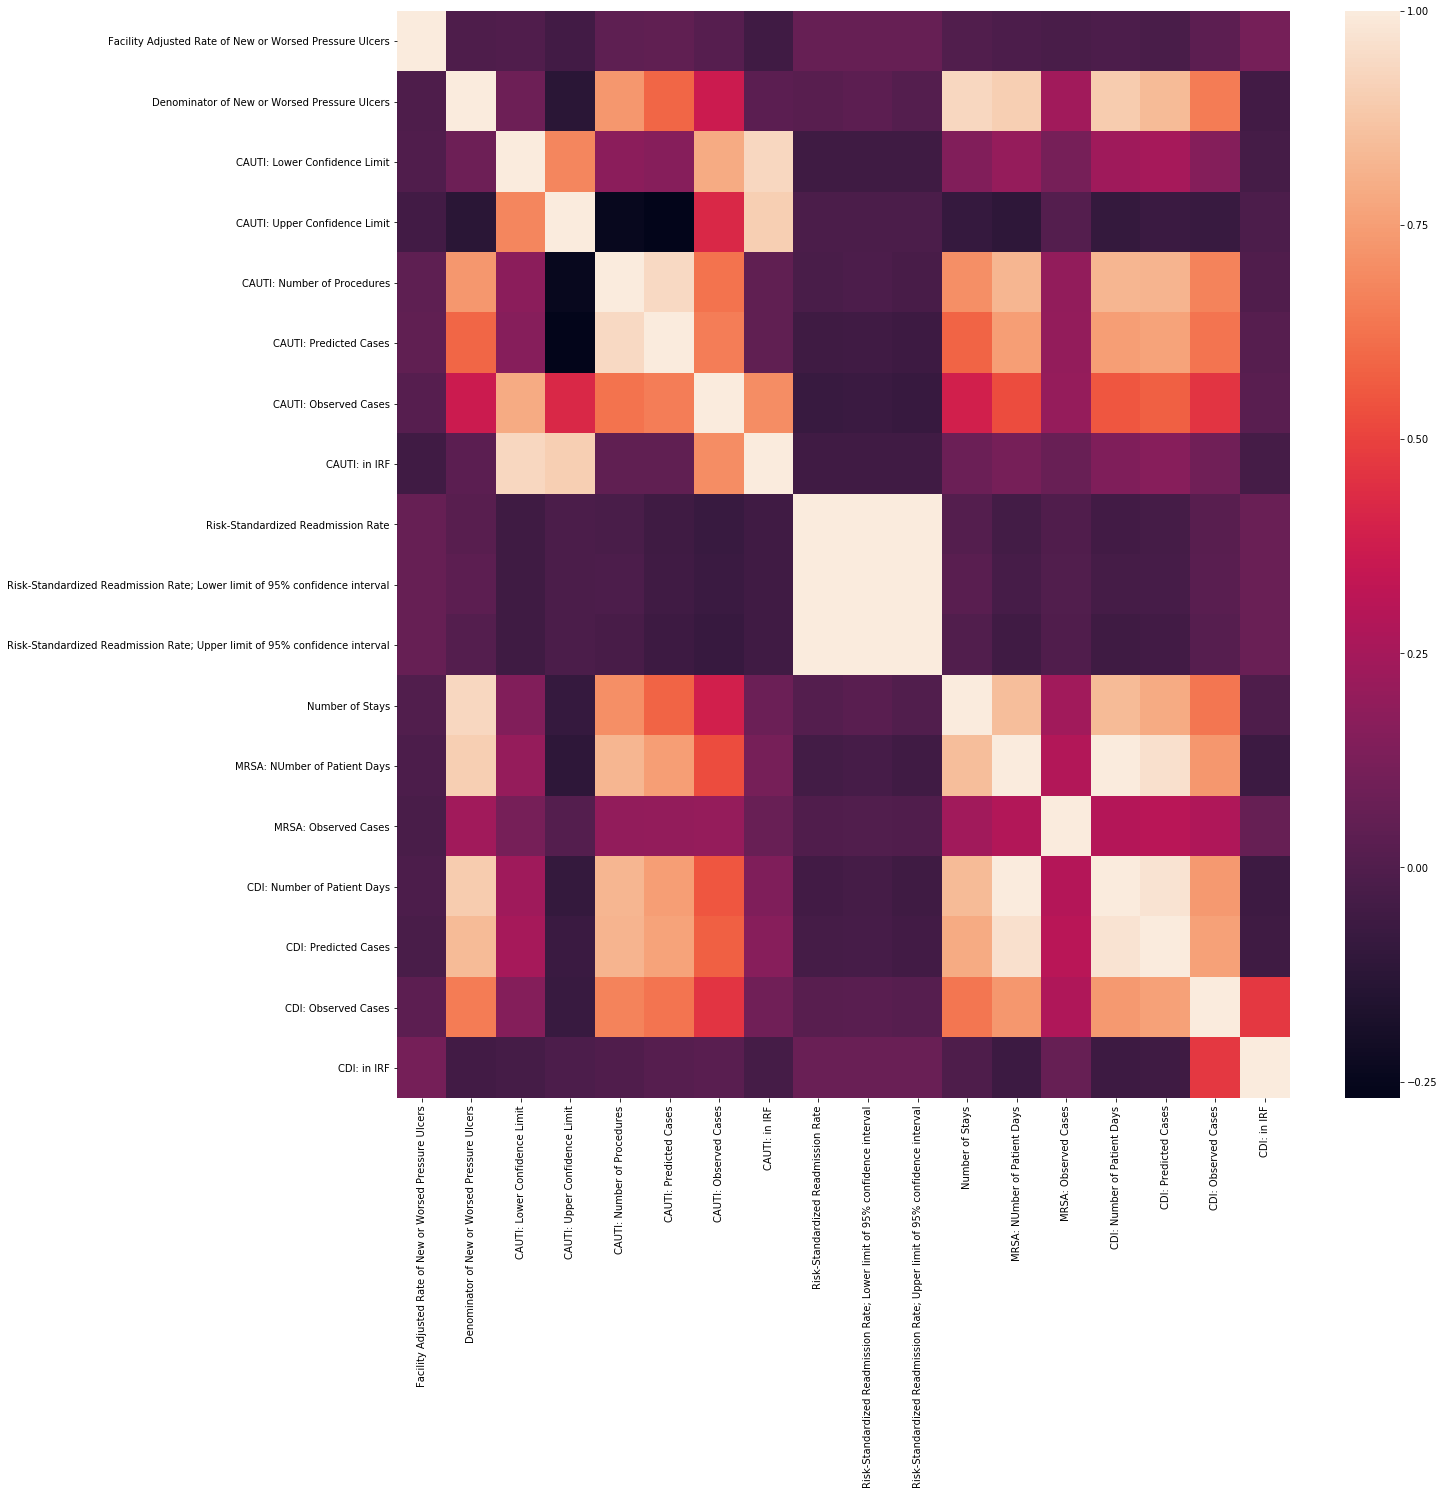

In [215]:
#Chop down the data we want to use for the heat map visualization
from copy import copy
vis_data = copy(facility_data)
vis_data = vis_data.drop(columns=[
    'I_002_01_DENOMINATOR',
    'I_002_01_OBS_RATE',
    'I_006_01_COMP_PERF',
    'I_007_01_COMP_PERF',
    'I_014_01_COMP_PERF',
    'I_014_01_CI_UPPER',
    'I_014_01_CI_LOWER',
    'I_014_01_ELIGCASES',
    'I_014_01_SIR',
    'I_015_01_COMP_PERF',
    'I_015_01_CI_UPPER',
    'I_015_01_CI_LOWER',
    'I_016_01_DENOMINATOR',
    'I_016_01_OBS_RATE'
])

#Produce correlation heat map
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
vis_data_corr = vis_data.corr()
sns.heatmap(vis_data_corr, 
            ax=ax,
            xticklabels=[headers_to_labels[val] for val in vis_data_corr.columns.values],
            yticklabels=[headers_to_labels[val] for val in vis_data_corr.columns.values])

Notes on abbreviations:
- **CAUTI** = Catheter-Associated Urinary Tract Infections
- **IRF** = Inpatient Rehabilitation Facility
- **MRSA** =  Methicillin-resistant Staphylococcus aureus Bacterial Infection
- **CDI** =  Clostridium difficile Infection

Correlation matrix wasn't as enlightening as I'd hoped. The risk-standardized readmission rate has almost no correlation with any other variable in the matrix, so not a lot can be drawn from that. Going to see what else I can demonstrate by crossing over the readmission rate with the counts of the conditions table.

In [216]:
national_data

,CMS Certification Number (CCN),Measure Code,Score,Footnote,Start Date,End Date
0,Nation,I_001_01_ADJ_RATE,0.500,NaN,04/01/2016,03/31/2017
1,Nation,I_002_01_OBS_RATE,93.500,NaN,10/01/2016,03/31/2017
2,Nation,I_006_01_SIR,1.060,NaN,04/01/2016,03/31/2017
3,Nation,I_007_01_N_BETTER_NAT,412.000,NaN,01/01/2014,12/31/2015
4,Nation,I_007_01_N_NO_DIFF_NAT,307.000,NaN,01/01/2014,12/31/2015
5,Nation,I_007_01_N_TOO_SMALL,11.000,NaN,01/01/2014,12/31/2015
6,Nation,I_007_01_N_WORSE_NAT,388.000,NaN,01/01/2014,12/31/2015
7,Nation,I_007_01_RSRR,13.390,NaN,01/01/2014,12/31/2015
8,Nation,I_014_01_SIR,1.170,NaN,04/01/2016,03/31/2017
9,Nation,I_015_01_SIR,1.006,NaN,04/01/2016,03/31/2017


In [217]:
general_info

,CMS Certification Number (CCN),Facility Name,Address Line 1,Address Line 2,City,State,Zip Code,County Name,PhoneNumber,CMS Region,Ownership Type,Certification Date
0,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,For profit,10/01/1983
1,013029,HEALTHSOUTH REHABILITATION HOSPITAL OF NORTH AL,107 GOVERNORS DRIVE,NaN,HUNTSVILLE,AL,35801,Madison,(205) 535-2300,4,For profit,06/04/1987
2,013028,HEALTHSOUTH REHABILITATION HOSPITAL OF MONTGOMERY,4465 NARROW LANE RD,NaN,MONTGOMERY,AL,36116,Montgomery,(334) 284-7821,4,For profit,05/11/1987
3,013030,HEALTHSOUTH REHABILITATION HOSPITAL,1736 EAST MAIN STREET,NaN,DOTHAN,AL,36301,Houston,(334) 712-6333,4,For profit,05/12/1994
4,013032,HEALTHSOUTH REHABILITATION HOSPITAL OF GADSDEN,801 GOODYEAR AVE,NaN,GADSDEN,AL,35903,Etowah,(256) 439-5000,4,For profit,08/14/2001
5,013033,REGIONAL REHABILITATION HOSPITAL,3715 HIGHWAY 280,NaN,PHENIX CITY,AL,36869,Russell,(334) 732-2200,4,For profit,11/12/2003
6,01T011,ST. VINCENTS EAST REHABILITATION CENTER,50 MEDICAL PARK EAST DRIVE,NaN,BIRMINGHAM,AL,35235,Jefferson,(205) 838-3672,4,Non-profit,04/30/1998
7,01T029,EAMC- LANIER,2000 PEPPERELL PARKWAY.,NaN,OPELIKA,AL,36801,Lee,(502) 596-6346,4,Government,10/01/2016
8,01T033,SPAIN REHABILITATION CENTER,SRC 223E,NaN,BIRMINGHAM,AL,35249,Jefferson,(205) 934-4940,4,Government,10/01/1997
9,01T092,NORTHPORT MEDICAL CENTER,"809 UNIVERSITY BOULEVARD, EAST",NaN,TUSCALOOSA,AL,35401,Tuscaloosa,(205) 759-7111,4,Government,05/01/2011


In [218]:
conditions

,CMS Certification Number (CCN),Facility Name,Address Line 1,Address Line 2,City,State,Zip Code,County Name,PhoneNumber,CMS Region,Condition,Count
0,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Stroke,318
1,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Nervous system disorder (excluding stroke),576
2,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Brain disease or condition (non-traumatic),174
3,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Brain injury (traumatic),77
4,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Spinal cord disease or condition (non-traumatic),81
5,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Spinal cord injury (traumatic),38
6,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,Hip or femur fracture,218
7,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,"Hip or knee replacement, amputation or other b...",528
8,013025,HEALTHSOUTH LAKESHORE REHABILITATION HOSPITAL,3800 RIDGEWAY DRIVE,NaN,BIRMINGHAM,AL,35209,Jefferson,(205) 868-2000,4,All other conditions,249
9,013029,HEALTHSOUTH REHABILITATION HOSPITAL OF NORTH AL,107 GOVERNORS DRIVE,NaN,HUNTSVILLE,AL,35801,Madison,(205) 535-2300,4,Stroke,291


So here's my next thought. Maybe I can demonstrate that certain types of conditions are associated with a higher rate of readmission and ask why that would be. Let's see what I find out.

I'm going to go about this by checking the different condition types as a fraction of the total number of conditions treated at the facility, then comparing that to the readmission rate. For the sake of simplicity, we'll treat any 'less than 11' values as a zero since it shouldn't dramatically bias our data.

In [303]:
#Create a new dataframe that uses the conditions as a fractional value of all treated conditions
conditions_datadict = dict((condition,pd.Series([])) for condition in conditions['Condition'].unique())
conditions_datadict = {**conditions_datadict, **{"CMS Certification Number (CCN)": pd.Series([])}}

#Iterate over CCNs, add to dict
for ccn in conditions["CMS Certification Number (CCN)"].unique():
    conditions_datadict["CMS Certification Number (CCN)"] = conditions_datadict["CMS Certification Number (CCN)"].append(
        pd.Series(ccn),
        ignore_index=True
    )
    
    #Iterate over conditions for associated CCN, extract value and append to dictionary
    for condition in conditions['Condition'].unique():
        val = conditions.loc[
            (conditions["CMS Certification Number (CCN)"] == ccn) &
            (conditions["Condition"] == condition)
        ]["Count"]
        conditions_datadict[condition] = conditions_datadict[condition].append(pd.Series(val), ignore_index=True)
        
#Dump conditions_datadict into a dataframe
facility_conditions = pd.DataFrame(conditions_datadict)
facility_conditions

,All other conditions,Brain disease or condition (non-traumatic),Brain injury (traumatic),CMS Certification Number (CCN),Hip or femur fracture,"Hip or knee replacement, amputation or other bone or joint condition",Nervous system disorder (excluding stroke),Spinal cord disease or condition (non-traumatic),Spinal cord injury (traumatic),Stroke
0,249,174,77,013025,218,528,576,81,38,318
1,344,69,44,013029,112,272,142,41,less than 11,291
2,380,66,23,013028,149,236,267,41,11,299
3,96,408,63,013030,75,189,116,87,less than 11,239
4,224,63,22,013032,105,168,177,23,less than 11,163
5,382,102,17,013033,91,230,103,30,less than 11,188
6,72,less than 11,less than 11,01T011,35,43,14,less than 11,less than 11,53
7,14,less than 11,less than 11,01T029,11,11,28,less than 11,less than 11,25
8,85,62,16,01T033,45,89,25,58,13,100
9,113,less than 11,11,01T092,93,56,19,21,less than 11,168


In [304]:
#Get rid of 'less than 11' values, convert colmn to numeric values
for condition in conditions["Condition"].unique():
    facility_conditions[condition].replace('less than 11', 0, inplace=True)
    facility_conditions[condition].replace('Not Available', np.nan, inplace=True)
    facility_conditions[condition] = facility_conditions[condition].apply(pd.to_numeric)

In [305]:
#Drop rows that sum to 0
sumvec = facility_conditions.sum(axis=1)
facility_conditions = facility_conditions[~(sumvec == 0)]

#Get percentages for remaining rows
sumvec = facility_conditions.sum(axis=1)
facility_conditions = pd.DataFrame({
    #Extract each column, divide and push back into df
    **dict(
        (condition, facility_conditions[condition].div(sumvec))
        for condition in conditions['Condition'].unique()
    ),
    #Append the CMS number
    **{'CMS Certification Number (CCN)' : facility_conditions['CMS Certification Number (CCN)']}
})

In [306]:
#Merge the risk-standardized readmission rate into the dataframe
facility_conditions = facility_conditions.merge(
    facility_data[['I_007_01_RSRR', 'CMS Certification Number (CCN)']],
    on='CMS Certification Number (CCN)',
    validate='one_to_one'
)

In [307]:
#Sanity check the CCN column by making sure there's only one row per CCN
assert(len(facility_conditions['CMS Certification Number (CCN)']) == len(facility_conditions['CMS Certification Number (CCN)'].unique()))

In [308]:
facility_conditions

,All other conditions,Brain disease or condition (non-traumatic),Brain injury (traumatic),CMS Certification Number (CCN),Hip or femur fracture,"Hip or knee replacement, amputation or other bone or joint condition",Nervous system disorder (excluding stroke),Spinal cord disease or condition (non-traumatic),Spinal cord injury (traumatic),Stroke,I_007_01_RSRR
0,0.110226,0.077025,0.034086,013025,0.096503,0.233732,0.254980,0.035857,0.016822,0.140770,NaN
1,0.261597,0.052471,0.033460,013029,0.085171,0.206844,0.107985,0.031179,0.000000,0.221293,NaN
2,0.258152,0.044837,0.015625,013028,0.101223,0.160326,0.181386,0.027853,0.007473,0.203125,NaN
3,0.075412,0.320503,0.049489,013030,0.058916,0.148468,0.091123,0.068342,0.000000,0.187745,NaN
4,0.237037,0.066667,0.023280,013032,0.111111,0.177778,0.187302,0.024339,0.000000,0.172487,NaN
5,0.334208,0.089239,0.014873,013033,0.079615,0.201225,0.090114,0.026247,0.000000,0.164479,NaN
6,0.331797,0.000000,0.000000,01T011,0.161290,0.198157,0.064516,0.000000,0.000000,0.244240,NaN
7,0.157303,0.000000,0.000000,01T029,0.123596,0.123596,0.314607,0.000000,0.000000,0.280899,NaN
8,0.172414,0.125761,0.032454,01T033,0.091278,0.180527,0.050710,0.117647,0.026369,0.202840,13.92
9,0.234927,0.000000,0.022869,01T092,0.193347,0.116424,0.039501,0.043659,0.000000,0.349272,13.50


In [309]:
facility_conditions.corr()

,All other conditions,Brain disease or condition (non-traumatic),Brain injury (traumatic),Hip or femur fracture,"Hip or knee replacement, amputation or other bone or joint condition",Nervous system disorder (excluding stroke),Spinal cord disease or condition (non-traumatic),Spinal cord injury (traumatic),Stroke,I_007_01_RSRR
All other conditions,1.000000,-0.037923,-0.205882,0.036733,-0.153341,-0.044362,-0.148654,-0.084654,-0.425119,0.137698
Brain disease or condition (non-traumatic),-0.037923,1.000000,0.206280,-0.309236,-0.169012,0.082231,0.224375,0.085234,-0.181226,0.014019
Brain injury (traumatic),-0.205882,0.206280,1.000000,-0.241562,-0.084583,-0.108509,0.186884,0.184495,0.012149,-0.100621
Hip or femur fracture,0.036733,-0.309236,-0.241562,1.000000,0.226596,-0.121932,-0.218444,-0.155599,-0.366487,0.032561
"Hip or knee replacement, amputation or other bone or joint condition",-0.153341,-0.169012,-0.084583,0.226596,1.000000,0.001054,-0.136682,-0.058440,-0.429551,0.008583
Nervous system disorder (excluding stroke),-0.044362,0.082231,-0.108509,-0.121932,0.001054,1.000000,-0.092673,-0.066154,-0.463956,0.153724
Spinal cord disease or condition (non-traumatic),-0.148654,0.224375,0.186884,-0.218444,-0.136682,-0.092673,1.000000,0.267470,-0.053703,-0.113000
Spinal cord injury (traumatic),-0.084654,0.085234,0.184495,-0.155599,-0.058440,-0.066154,0.267470,1.000000,0.004450,-0.065668
Stroke,-0.425119,-0.181226,0.012149,-0.366487,-0.429551,-0.463956,-0.053703,0.004450,1.000000,-0.142808
I_007_01_RSRR,0.137698,0.014019,-0.100621,0.032561,0.008583,0.153724,-0.113000,-0.065668,-0.142808,1.000000


Meh. There's only a very weak correlation between nervous system disorders and readmission - which is a good thing. But the weak correlation likely means there's lots of facilities that have unusually high readmission rates. Let's scatterplot it and see what happens.

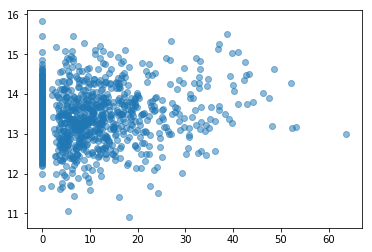

In [322]:
plt.scatter(
    facility_conditions['Nervous system disorder (excluding stroke)'] * 100,
    facility_conditions['I_007_01_RSRR'],
    alpha=.5
)
plt.show()

Right, this is roughly what I figured: plenty of places with no nervous system conditions, then some high-readmission sites that fall right in the middle. We can probably look at the places with high rates of readmission and dig into those; there might be a correlation when we slice down the amount of data.

In [318]:
#Select top 100 facilities by readmission rate, plot
facility_conditions.sort_values('I_007_01_RSRR', inplace=True)
facility_conditions[-100:].corr()

,All other conditions,Brain disease or condition (non-traumatic),Brain injury (traumatic),Hip or femur fracture,"Hip or knee replacement, amputation or other bone or joint condition",Nervous system disorder (excluding stroke),Spinal cord disease or condition (non-traumatic),Spinal cord injury (traumatic),Stroke,I_007_01_RSRR
All other conditions,1.000000,-0.076436,-0.178825,0.053073,-0.270066,-0.193228,-0.307101,-0.006933,-0.216522,-0.152386
Brain disease or condition (non-traumatic),-0.076436,1.000000,0.421286,-0.230952,-0.232762,0.028450,0.184974,-0.039474,-0.190333,-0.168507
Brain injury (traumatic),-0.178825,0.421286,1.000000,-0.105233,-0.113390,-0.199375,0.245381,0.091103,-0.018414,0.166613
Hip or femur fracture,0.053073,-0.230952,-0.105233,1.000000,0.370634,-0.227206,-0.127923,-0.221164,-0.397639,0.392964
"Hip or knee replacement, amputation or other bone or joint condition",-0.270066,-0.232762,-0.113390,0.370634,1.000000,-0.048166,-0.054717,0.075037,-0.476170,0.393107
Nervous system disorder (excluding stroke),-0.193228,0.028450,-0.199375,-0.227206,-0.048166,1.000000,-0.055176,-0.102608,-0.429389,-0.133156
Spinal cord disease or condition (non-traumatic),-0.307101,0.184974,0.245381,-0.127923,-0.054717,-0.055176,1.000000,0.231709,-0.031203,-0.088348
Spinal cord injury (traumatic),-0.006933,-0.039474,0.091103,-0.221164,0.075037,-0.102608,0.231709,1.000000,0.026118,-0.085391
Stroke,-0.216522,-0.190333,-0.018414,-0.397639,-0.476170,-0.429389,-0.031203,0.026118,1.000000,-0.244952
I_007_01_RSRR,-0.152386,-0.168507,0.166613,0.392964,0.393107,-0.133156,-0.088348,-0.085391,-0.244952,1.000000


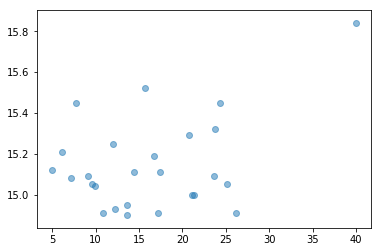

In [320]:
plt.scatter(
    facility_conditions[-100:]['Hip or knee replacement, amputation or other bone or joint condition'] * 100,
    facility_conditions[-100:]['I_007_01_RSRR'],
    alpha=.5
)
plt.show()

In [321]:
facility_conditions.shape

(1101, 11)

OK, our highest Pearson coefficients run around .39, which is only a weak/moderate correlation in linear space. I have one last thing to test out before I throw in the towel. I'm going to try and fit a ridge regression model with cross-validation and see how well it explains the data in testing using L^2 error.

In [326]:
#Remove all rows in facility_conditions that has NaN for readmission rate
facility_conditions_clean = facility_conditions.loc[
    ~(facility_conditions['I_007_01_RSRR'].isnull())
]
len(facility_conditions_clean)

1027

In [337]:
#We'll reduce the dimensionality as well so that we're only using the most precient features
facility_conditions_clean.var()

All other conditions                                                    0.011984
Brain disease or condition (non-traumatic)                              0.002667
Brain injury (traumatic)                                                0.001632
Hip or femur fracture                                                   0.008396
Hip or knee replacement, amputation or other bone or joint condition    0.008192
Nervous system disorder (excluding stroke)                              0.010638
Spinal cord disease or condition (non-traumatic)                        0.002122
Spinal cord injury (traumatic)                                          0.000119
Stroke                                                                  0.031704
I_007_01_RSRR                                                           0.492513
dtype: float64

In [346]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(
    facility_conditions_clean.drop(
        ['I_007_01_RSRR','CMS Certification Number (CCN)'],
        axis=1
    ),
    facility_conditions_clean['I_007_01_RSRR'],
    test_size=.8
)

# Make a pipeline model with polynomial transformation 
#and LASSO regression with cross-validation, 
#run it for increasing degree of polynomial (complexity of the model)

model = RidgeCV(
    alphas=[x * .01 for x in range(0, 100)],
    cv=5,
    fit_intercept=True,
    normalize=True
)

model.fit(X_train,y_train)
test_pred = np.array(model.predict(X_test))
RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
test_score = model.score(X_test,y_test)

C:\Users\spenc\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.556171780304469e-17 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\spenc\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.633970345102739e-18 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\spenc\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.1826379331333374e-17 / 1.1102230246251565e-16
  RuntimeWarning)


In [347]:
test_score

0.02829699497429483

Well, we're cooked. The optimal for the score is 1 and we're not even cresting .03.